In [ ]:
!pip uninstall numpy -y
!pip install numpy==1.23.5

import numpy as np
import random
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.distributions import Categorical
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import TensorDataset, DataLoader

from gym.envs import register
import gym
import gym.spaces as Space

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

#bool8 still in use in gym's librairy for some reason..
np.bool8 = np.bool_

In [3]:
class BackboneNetwork(nn.Module):
    """
    Purpose:
        TThis class represents a neural network backbone designed for reinforcement learning agents, specifically for PPO 
        (Proximal Policy Optimization) and A2C (Advantage Actor-Critic) algorithms, designed to process input features
        and produce either policy predictions (for the actor) or value estimations (for the critic). The network includes
        multiple layers, dropout for regularization, and an activation function for non-linearity. It also includes several 
    
    Arguments:
        in_features (int): The number of input features to the network.
        hidden_dimensions (int): The number of neurons in the hidden layers.
        out_features (int): The number of output features (e.g., action probabilities for the actor, value estimate for the critic).
        dropout (float): Dropout probability for regularization.
        activation (callable, optional): Activation function applied after each layer. Default is ReLU.

    Notes:
        - Xavier Initialization: The network weights are initialized using Xavier uniform initialization to ensure stable gradients.
        - Gradient Clipping: Gradients are clipped during training to prevent explosion or vanishing gradients.
        - Scheduler: A learning rate scheduler adjusts the learning rate dynamically during training for better convergence.
        - Entropy Coefficient: This regularization encourages exploration by preventing the policy from becoming deterministic too early.
    
    Output:
        Tensor: The processed output tensor from the final layer of the network.
    """
    def __init__(self, in_features, hidden_dimensions, out_features, dropout, activation=F.relu):
        super().__init__()
        self.layer1 = nn.Linear(in_features, hidden_dimensions)
        self.layer2 = nn.Linear(hidden_dimensions, hidden_dimensions)
        self.layer3 = nn.Linear(hidden_dimensions, out_features)
        self.dropout = nn.Dropout(dropout)
        self.activation = activation
    
    def forward(self, x):
        x = self.layer1(x)
        x = self.activation(x) 
        x = self.dropout(x)
        x = self.layer2(x)
        x = self.activation(x) 
        x = self.dropout(x)
        x = self.layer3(x)
        return x

class ActorCritic(nn.Module):
    def __init__(self, actor, critic):
        super().__init__()
        self.actor = actor
        self.critic = critic
        
    def forward(self, state):
        action_pred = self.actor(state)
        value_pred = self.critic(state)
        return action_pred, value_pred

class Mish(nn.Module):
    def __init__(self): super().__init__()
    def mish(self, input): return input * torch.tanh(F.softplus(input))
    def forward(self, input): return self.mish(input)
        
def create_agent(hidden_dimensions, dropout):
    INPUT_FEATURES = env_train.observation_space.shape[0]
    HIDDEN_DIMENSIONS = hidden_dimensions
    ACTOR_OUTPUT_FEATURES = env_train.action_space.n
    CRITIC_OUTPUT_FEATURES = 1
    DROPOUT = dropout
    actor = BackboneNetwork(
            INPUT_FEATURES, HIDDEN_DIMENSIONS, ACTOR_OUTPUT_FEATURES, DROPOUT)
    actor.apply(init_xavier_weights)
    critic = BackboneNetwork(
            INPUT_FEATURES, HIDDEN_DIMENSIONS, CRITIC_OUTPUT_FEATURES, DROPOUT)
    critic.apply(init_xavier_weights)
    agent = ActorCritic(actor, critic)
    return agent

def init_xavier_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)

def calculate_returns(rewards, discount_factor):
    returns = []
    cumulative_reward = 0
    for r in reversed(rewards):
        cumulative_reward = r + cumulative_reward * discount_factor
        returns.insert(0, cumulative_reward)
    returns = torch.tensor(returns)
    return normalize_rewards(returns)

def calculate_advantages(returns, values):
    advantages = returns - values
    normalized_advantages = (advantages - advantages.mean()) / advantages.std()
    return normalized_advantages

def calculate_surrogate_loss(
        actions_log_probability_old,
        actions_log_probability_new,
        epsilon,
        advantages):
    advantages = advantages.detach()
    policy_ratio = (
            actions_log_probability_new - actions_log_probability_old
            ).exp()
    surrogate_loss_1 = policy_ratio * advantages
    surrogate_loss_2 = torch.clamp(
            policy_ratio, min=1.0-epsilon, max=1.0+epsilon
            ) * advantages
    surrogate_loss = torch.min(surrogate_loss_1, surrogate_loss_2)
    return surrogate_loss

# Loss function for PPO
def calculate_ppo_losses(
        surrogate_loss, entropy, entropy_coefficient, returns, value_pred):
    entropy_bonus = entropy_coefficient * entropy
    policy_loss = -(surrogate_loss + entropy_bonus).sum()
    value_loss = F.smooth_l1_loss(returns, value_pred).sum()
    return policy_loss, value_loss

# Loss function for A2C
def calculate_a2c_losses(log_prob, advantages, value_pred, returns, entropy, entropy_coefficient):
    entropy_bonus = entropy_coefficient * entropy  #.mean()
    policy_loss = -(log_prob * advantages.detach() + entropy_bonus).sum() #.mean()
    value_loss = F.smooth_l1_loss(value_pred, returns).sum()
    return policy_loss, value_loss, entropy_bonus

def clip_grad_norm_(module, max_grad_norm):
    total_norm = nn.utils.clip_grad_norm_([p for g in module.param_groups for p in g["params"]], max_grad_norm)

def normalize_rewards(r):
    mean = r.mean()
    std = r.std() + 1e-8  
    return (r - mean) / std

def init_training():
    states = []
    actions = []
    actions_log_probability = []
    values = []
    rewards = []
    done = False
    episode_reward = 0
    return states, actions, actions_log_probability, values, rewards, done, episode_reward

def forward_pass(env, agent, optimizer, discount_factor):
    states, actions, actions_log_probability, values, rewards, done, episode_reward = init_training()
    state = env.reset()
    agent.train()
    step_counter = 0
    while not done:
        state = state[0] if isinstance(state, tuple) else state
        state = torch.FloatTensor(state).unsqueeze(0).view(1, -1)
        states.append(state)
        action_pred, value_pred = agent(state)
        action_prob = F.softmax(action_pred, dim=-1)
        dist = torch.distributions.Categorical(action_prob)
        action = dist.sample()
        log_prob_action = dist.log_prob(action)
        state, reward, done, info, _ = env.step(action.item())
        actions.append(action)
        actions_log_probability.append(log_prob_action)
        values.append(value_pred)
        rewards.append(reward)
        episode_reward += reward
    states = torch.cat(states)
    actions = torch.cat(actions)
    actions_log_probability = torch.cat(actions_log_probability)
    values = torch.cat(values).squeeze(-1)
    returns = calculate_returns(rewards, discount_factor)
    advantages = calculate_advantages(returns, values)
    return episode_reward, states, actions, actions_log_probability, advantages, returns

def update_policy(
        agent,
        states,
        actions,
        actions_log_probability_old,
        advantages,
        returns,
        optimizer,
        scheduler,
        max_grad_norm,
        ppo_steps,
        epsilon,
        entropy_coefficient,
        ALGORITHM):
    BATCH_SIZE = 128
    total_policy_loss = 0
    total_value_loss = 0
    actions_log_probability_old = actions_log_probability_old.detach()
    actions = actions.detach()
    training_results_dataset = TensorDataset(
            states,
            actions,
            actions_log_probability_old,
            advantages,
            returns)
    batch_dataset = DataLoader(
            training_results_dataset,
            batch_size=BATCH_SIZE,
            shuffle=False)
    for _ in range(ppo_steps):
        for batch_idx, (states, actions, actions_log_probability_old, advantages, returns) in enumerate(batch_dataset):
            action_pred, value_pred = agent(states)
            value_pred = value_pred.squeeze(-1)
            action_prob = F.softmax(action_pred, dim=-1)
            probability_distribution_new = torch.distributions.Categorical(
                    action_prob)
            entropy = probability_distribution_new.entropy()
            actions_log_probability_new = probability_distribution_new.log_prob(actions)
            surrogate_loss = calculate_surrogate_loss(
                    actions_log_probability_old,
                    actions_log_probability_new,
                    epsilon,
                    advantages)
            if ALGORITHM == "PPO":
                # Compute PPO losses
                policy_loss, value_loss = calculate_ppo_losses(
                        surrogate_loss,
                        entropy,
                        entropy_coefficient,
                        returns,
                        value_pred)
            elif ALGORITHM == "A2C":
                # Compute A2C losses
                policy_loss, value_loss, entropy_bonus = calculate_a2c_losses(
                    actions_log_probability_new, 
                    advantages, 
                    value_pred, 
                    returns, 
                    entropy, 
                    entropy_coefficient)
            else:
                raise Exception("Incorrect algorithm called.")
            optimizer.zero_grad()
            policy_loss.backward()
            value_loss.backward()
            # Clipping gradient to avoid explosion or vanishing gradient
            clip_grad_norm_(optimizer, max_grad_norm)
            optimizer.step()
            # Scheduler to dynamically adjust the learning rate over training
            scheduler.step()
            current_lr = scheduler.get_last_lr()[0]
            total_policy_loss += policy_loss.item()
            total_value_loss += value_loss.item()
    return total_policy_loss / ppo_steps, total_value_loss / ppo_steps

def evaluate(env, agent):
    agent.eval()
    rewards = []
    done = False
    episode_reward = 0
    state = env.reset()
    while not done:
        state = state[0] if isinstance(state, tuple) else state
        state = torch.FloatTensor(state).unsqueeze(0).view(1, -1)
        with torch.no_grad():
            action_pred, _ = agent(state)
            action_prob = F.softmax(action_pred, dim=-1)
        action = torch.argmax(action_prob, dim=-1)
        state, reward, done, info, _ = env.step(action.item())
        episode_reward += reward
    return episode_reward

def plot_train_rewards(train_rewards, reward_threshold):
    plt.figure(figsize=(12, 8))
    plt.plot(train_rewards, label='Training Reward')
    plt.xlabel('Episode', fontsize=20)
    plt.ylabel('Training Reward', fontsize=20)
    plt.hlines(reward_threshold, 0, len(train_rewards), color='y')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

def plot_test_rewards(test_rewards, reward_threshold):
    plt.figure(figsize=(12, 8))
    plt.plot(test_rewards, label='Testing Reward')
    plt.xlabel('Episode', fontsize=20)
    plt.ylabel('Testing Reward', fontsize=20)
    plt.hlines(reward_threshold, 0, len(test_rewards), color='y')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

def plot_losses(policy_losses, value_losses):
    plt.figure(figsize=(8, 4))
    plt.plot(value_losses, label='Value Losses')
    plt.plot(policy_losses, label='Policy Losses')
    plt.xlabel('Episode', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

def run_agent(algorithm):
    MAX_EPISODES = 60  
    DISCOUNT_FACTOR = 0.99  # A lower 𝛾 places more weight on immediate rewards and less weight on future rewards.
    REWARD_THRESHOLD = 15 
    MIN_REWARD_THRESHOLD = -10
    PRINT_INTERVAL = 10
    PPO_STEPS = 8
    N_TRIALS = 100
    EPSILON = 0.2
    ENTROPY_COEFFICIENT = 1000
    HIDDEN_DIMENSIONS = 64
    DROPOUT = 0.2
    LEARNING_RATE = 0.001
    MAX_GRAD_NORM = 100.0
    ALGORITHM = algorithm
    train_rewards = []
    test_rewards = []
    policy_losses = []
    value_losses = []
    agent = create_agent(HIDDEN_DIMENSIONS, DROPOUT)
    optimizer = torch.optim.Adam(agent.parameters(), lr=LEARNING_RATE)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.9)
    for episode in range(1, MAX_EPISODES+1):
        train_reward, states, actions, actions_log_probability, advantages, returns = forward_pass(
                env_train,
                agent,
                optimizer,
                DISCOUNT_FACTOR)
        policy_loss, value_loss = update_policy(
                agent,
                states,
                actions,
                actions_log_probability,
                advantages,
                returns,
                optimizer,
                scheduler,
                MAX_GRAD_NORM,
                PPO_STEPS,
                EPSILON,
                ENTROPY_COEFFICIENT,
                ALGORITHM)
        test_reward = evaluate(env_test, agent)
        policy_losses.append(policy_loss)
        value_losses.append(value_loss)
        train_rewards.append(train_reward)
        test_rewards.append(test_reward)
        mean_train_rewards = np.mean(train_rewards[-N_TRIALS:])
        mean_test_rewards = np.mean(test_rewards[-N_TRIALS:])
        mean_abs_policy_loss = np.mean(np.abs(policy_losses[-N_TRIALS:]))
        mean_abs_value_loss = np.mean(np.abs(value_losses[-N_TRIALS:]))
        if episode % PRINT_INTERVAL == 0:
            print(f'Episode: {episode:3} | \
                  Mean Train Rewards: {mean_train_rewards:3.1f} \
                  | Mean Test Rewards: {mean_test_rewards:3.1f} \
                  | Mean Abs Policy Loss: {mean_abs_policy_loss:2.2f} \
                  | Mean Abs Value Loss: {mean_abs_value_loss:2.2f}')
        if mean_test_rewards >= REWARD_THRESHOLD or mean_test_rewards<= MIN_REWARD_THRESHOLD:
            print(f'Reached reward threshold in {episode} episodes')
    plot_train_rewards(train_rewards, REWARD_THRESHOLD)
    plot_test_rewards(test_rewards, REWARD_THRESHOLD)
    plot_losses(policy_losses, value_losses)

In [4]:
class Environment(gym.Env):
    """
    Purpose: 
        This class represents a custom reinforcement learning environment for simulating the management of virtual machine (VM) 
        resources (CPU, memory, disk) and ensuring that the VM's response time meets the target requirement. The agent can adjust 
        the resources allocated to the VM and receive feedback on performance.
    
    Arguments:
        vm (VMClass): An instance of a virtual machine class containing the initial configuration of the VM (e.g., CPU, memory, disk, response time).
        render_mode (str, optional): The rendering mode to use. If provided, it should be either "human" or "rgb_array". Default is None.
    
    Output:
        None: Initializes the environment's parameters.
    """
    def __init__(self, vm, render_mode=None) -> None:
        super(Environment, self).__init__()

        self.metadata = {
        "render_modes": ["human", "rgb_array"],
        "render_fps": 20
            }
        self.window_size = 500
        self.vm = vm

        high = np.array(
            [
                1.0,
                1.0,
                1.0,
                self.vm.Requirement_ResTime
            ],
            dtype=np.float32,
        )

        low = np.array(
            [
                0.0,
                0.0,
                0.0,
                0.0
            ],
            dtype=np.float32,
        )

        self.observation_space = Space.Box(low, high, dtype=np.float32)

        self.action_space = Space.Discrete(4)

        # Mapping actions to the adjustement we will make to the allocated resources
        self.action_to_adjustement = [
            (-1, 0, 0),
            (0, -1, 0),
            (-3, 0, 0),
            (0, -3, 0)
        ]
        
        assert render_mode is None or render_mode in self.metadata["render_modes"]
        self.render_mode = render_mode
        self.window = None
        self.clock = None

    def step(self, action):
        """
        Executes an action in the environment, updates the system state, and calculates the reward.
        """
        err_msg = f"{action!r} ({type(action)}) invalid"
        assert self.action_space.contains(action), err_msg
        cpu_adjustment, mem_adjustment, disk_adjustment = self.action_to_adjustement[action]
        assert any([cpu_adjustment, mem_adjustment, disk_adjustment]
                   ), "Invalid action: all adjustments are set to zero."

        # Adjusting the system's resources
        if cpu_adjustment != 0:
            self.vm.VM_CPU_g = max(1, self.vm.VM_CPU_g + cpu_adjustment)
        if mem_adjustment != 0:
            self.vm.VM_Mem_g = max(1, self.vm.VM_Mem_g + mem_adjustment)
        if disk_adjustment != 0:
            self.vm.VM_Disk_g = max(1, self.vm.VM_Disk_g + disk_adjustment)

        # Computing the system's theoritical response time after the adjustement has been applied
        self.vm.calculate_throughput_response_time()

        # Computing the system's resource utilization ratios
        cpu_util = self.vm.VM_CPU_g / self.vm.VM_CPU_i
        mem_util = self.vm.VM_Mem_g / self.vm.VM_Mem_i
        disk_util = self.vm.VM_Disk_g / self.vm.VM_Disk_i

        # Setting the new system state
        self.state = (
            cpu_util,
            mem_util,
            disk_util,
            self.vm.ResponseTime
        )

        # Setting the termination conditions of an episode
        terminated = np.bool(
            self.vm.ResponseTime >= self.vm.Requirement_ResTime or
            cpu_util > 1.1 or
            cpu_util < 0.1 or
            mem_util > 1.1 or
            mem_util < 0.1 or
            disk_util > 1.1 or
            disk_util < 0.1
        )

        if terminated:
            reward = 0
        elif self.vm.ResponseTime <= self.vm.Requirement_ResTime:
            reward = 1
        return np.array(self.state, dtype=np.float32), reward, terminated, False, {}

    def render(self):
        if self.render_mode == "rgb_array":
            return self.render_frame()

    def render_frame(self):
        if self.window is None:
            pygame.init()
            self.window = pygame.display.set_mode(
                (self.window_size, self.window_size))
            self.clock = pygame.time.Clock()

        if self.render_mode == "rgb_array":
            self.window.fill((255, 255, 255))

            FONT = pygame.font.SysFont('Arial', 30)
            my_gauge = Gauge(
                screen=self.window,
                FONT=FONT,
                x_cord=self.window_size / 2,
                y_cord=self.window_size / 2,
                thickness=30,
                radius=150,
                circle_colour=(128, 128, 128),
                glow=False
            )

            percent = (self.vm.ResponseTime /
                       int(1.1 * self.vm.Requirement_ResTime)) * 100
            my_gauge.draw(percent)

            pygame.display.flip()
            self.clock.tick(self.metadata["render_fps"])

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.vm.ResponseTime_i = random.randint(
            int(self.vm.Requirement_ResTime * 0.4), 
            int(self.vm.Requirement_ResTime * 0.6))
        self.vm.VM_CPU_i = random.randint(self.vm.CpuCap -10, self.vm.CpuCap -5)
        self.vm.VM_Mem_i = random.randint(self.vm.MemCap -10, self.vm.MemCap -5)
        self.vm.VM_Disk_i = random.randint(self.vm.DiskCap -50, self.vm.DiskCap -20)

        self.vm.VM_CPU_g = self.vm.VM_CPU_i
        self.vm.VM_Mem_g = self.vm.VM_Mem_i
        self.vm.VM_Disk_g = self.vm.VM_Disk_i

        state = [
        self.vm.VM_CPU_g / self.vm.VM_CPU_i,
        self.vm.VM_Mem_g / self.vm.VM_Mem_i,
        self.vm.VM_Disk_g / self.vm.VM_Disk_i,
        self.vm.ResponseTime_i
        ]

        if self.render_mode == "human":
            self.render_frame()

        return np.array(state, dtype=np.float32), {}

    def close(self):
        if self.window is not None:
            pygame.display.quit()
            pygame.quit()


In [5]:
def initialize_vms(n, vms_cap_cpu, vms_cap_mem, vms_cap_disk, requirement_res_times, sensitivity_collection):
    """
    Purpose:
        Initialize a list of virtual machine (VM) instances with predefined configurations and return the list.
        
    Arguments:
        n (int): The number of virtual machines to initialize.
        vms_cap_cpu (float): The CPU capacity for the VMs.
        vms_cap_mem (float): The memory capacity for the VMs.
        vms_cap_disk (float): The disk capacity for the VMs.
        requirement_res_times (list): A list of required response times for the VMs.
        sensitivity_collection (list): A collection of sensitivity values to initialize the VMs.

    Returns:
        list: A list containing `n` initialized `VirtualMachine` instances.
    """
    vm_list = []

    for i in range(n):
        vm_cpu = vms_cap_cpu
        vm_mem = vms_cap_mem
        vm_disk = vms_cap_disk
        vm_res_time = 0.0
        vm_sensitivities = sensitivity_collection[i]
        vm_required_time = requirement_res_times[i]

        vm = VirtualMachine(
            cpu_g=vm_cpu,
            mem_g=vm_mem,
            disk_g=vm_disk,
            cpu_i=vm_cpu,
            mem_i=vm_mem,
            disk_i=vm_disk,
            sensitivity_values=sensitivity_collection[i],
            response_time_i=vm_res_time,
            Requirement_ResTime=vm_required_time,
            Acceptolerance=0.1  
        )

        vm_list.append(vm)

    return vm_list

In [6]:
class VirtualMachine:
    def __init__(self, cpu_g, mem_g, disk_g, cpu_i, mem_i, disk_i, sensitivity_values, response_time_i, Requirement_ResTime, Acceptolerance):
        self.VM_CPU_g = cpu_g
        self.VM_Mem_g = mem_g
        self.VM_Disk_g = disk_g
        self.VM_CPU_i = cpu_i
        self.VM_Mem_i = mem_i
        self.VM_Disk_i = disk_i
        self.VM_SensitivityValues = sensitivity_values
        self.ResponseTime_i = response_time_i
        self.Requirement_ResTime = Requirement_ResTime
        self.Acceptolerance = Acceptolerance
        self.Throughput = 0.0
        self.ResponseTime = 0.0
        self.CpuCap = cpu_g
        self.MemCap = mem_g
        self.DiskCap = disk_g

    def calculate_throughput_response_time(self):
        part1 = (self.VM_CPU_g / self.VM_CPU_i) * self.VM_SensitivityValues[0]
        part2 = (self.VM_Mem_g / self.VM_Mem_i) * self.VM_SensitivityValues[1]
        part3 = (self.VM_Disk_g / self.VM_Disk_i) * \
            self.VM_SensitivityValues[2]
        part4 = sum(self.VM_SensitivityValues)

        self.Throughput = ((part1 + part2 + part3) / part4) * \
            1000.0 / self.ResponseTime_i

        self.ResponseTime = round((1000.0 / self.Throughput) * 100.0) / 100.0

In [45]:
if "Env-v0" not in gym.envs.registry:
    register(
        id="Env-v0",
        entry_point="__main__:Environment",
        kwargs={"render_mode": "rgb_array"}
    )

requirement_res_times = [3000, 3050, 3100, 3100]
sensitivity_collection = [
    [0.79, 0.19, 0.01],
    [0.74, 0.24, 0.01],
    [0.27, 0.63, 0.10],
    [0.42, 0.50, 0.07]]

vms = initialize_vms(4, 25, 25, 100, requirement_res_times, sensitivity_collection)
print(f"Initialized {len(vms)} VMs.")

# Running the stress test on the first VM.
vm = vms[0]

env_train = gym.make("Env-v0", vm=vm, render_mode="rgb_array")
env_test = gym.make("Env-v0", vm=vm, render_mode="rgb_array")

Initialized 4 VMs.


#### Results from the PPO agent:

Initialized 4 VMs.
Episode:  10 |                   Mean Train Rewards: 9.7                   | Mean Test Rewards: 9.4                   | Mean Abs Policy Loss: 47.37                   | Mean Abs Value Loss: 75.07
Episode:  20 |                   Mean Train Rewards: 10.6                   | Mean Test Rewards: 10.2                   | Mean Abs Policy Loss: 46.67                   | Mean Abs Value Loss: 50.81
Episode:  30 |                   Mean Train Rewards: 12.2                   | Mean Test Rewards: 11.1                   | Mean Abs Policy Loss: 48.87                   | Mean Abs Value Loss: 37.26
Episode:  40 |                   Mean Train Rewards: 12.9                   | Mean Test Rewards: 12.0                   | Mean Abs Policy Loss: 39.77                   | Mean Abs Value Loss: 28.43
Episode:  50 |                   Mean Train Rewards: 13.5                   | Mean Test Rewards: 12.6                   | Mean Abs Policy Loss: 32.35                   | Mean Abs Value Loss: 22.8

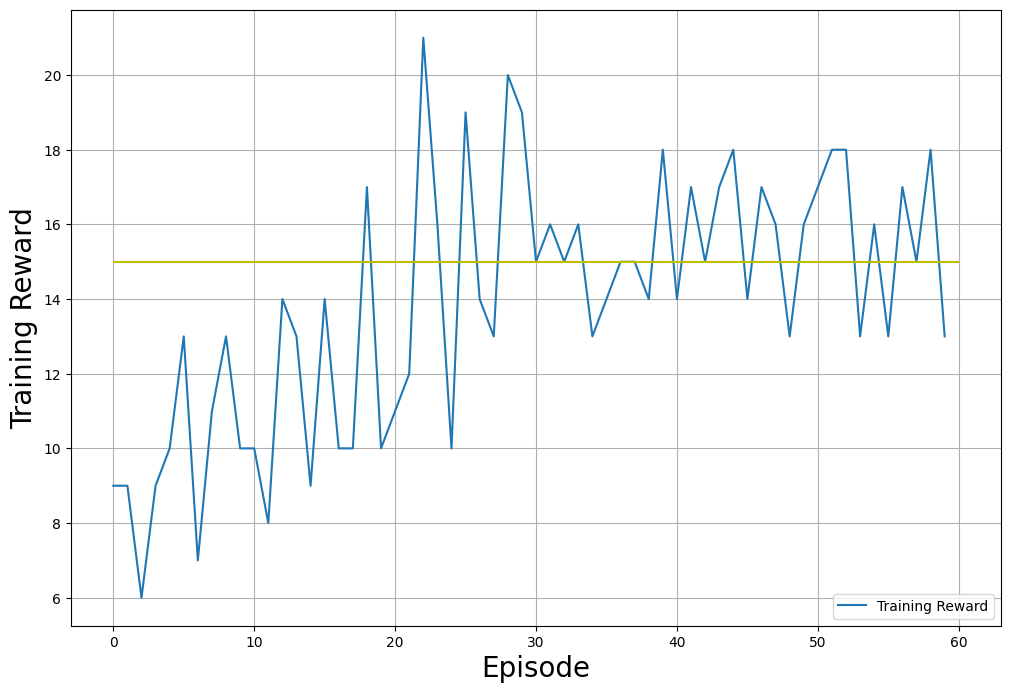

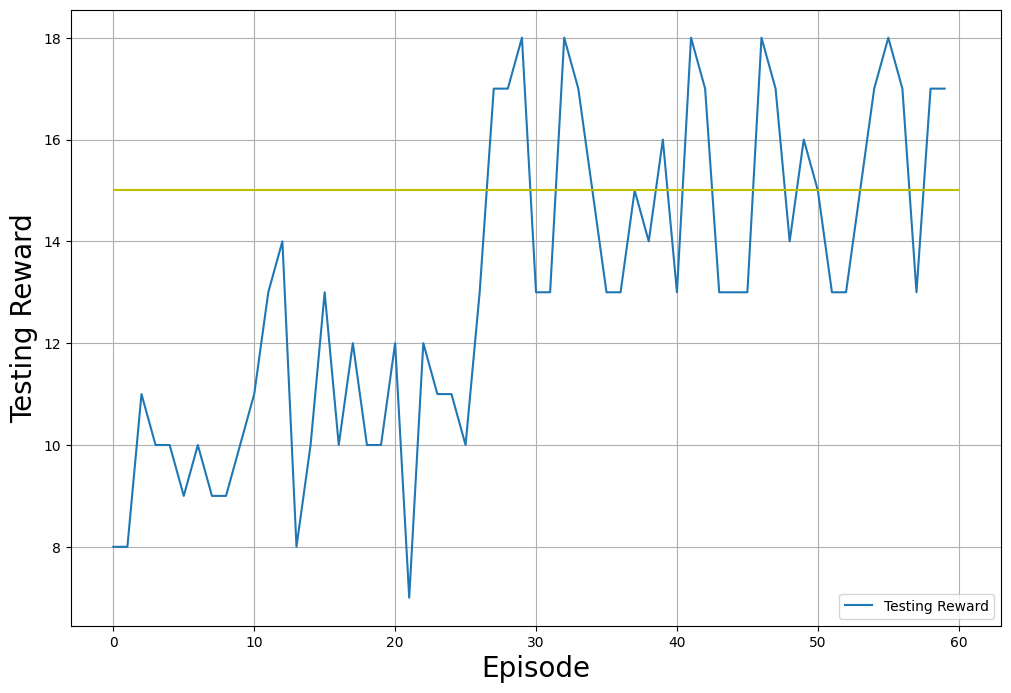

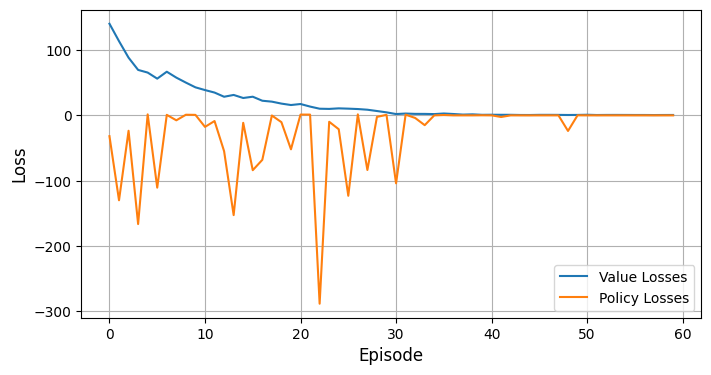

In [615]:
run_agent(algorithm="PPO")

#### Results from the A2C agent:

Episode:  10 |                   Mean Train Rewards: 7.8                   | Mean Test Rewards: 7.5                   | Mean Abs Policy Loss: 86.73                   | Mean Abs Value Loss: 94.02
Episode:  20 |                   Mean Train Rewards: 6.3                   | Mean Test Rewards: 6.2                   | Mean Abs Policy Loss: 57.05                   | Mean Abs Value Loss: 70.28
Episode:  30 |                   Mean Train Rewards: 5.4                   | Mean Test Rewards: 5.2                   | Mean Abs Policy Loss: 42.00                   | Mean Abs Value Loss: 54.41
Episode:  40 |                   Mean Train Rewards: 5.0                   | Mean Test Rewards: 4.6                   | Mean Abs Policy Loss: 36.81                   | Mean Abs Value Loss: 44.33
Episode:  50 |                   Mean Train Rewards: 5.4                   | Mean Test Rewards: 5.3                   | Mean Abs Policy Loss: 34.41                   | Mean Abs Value Loss: 36.73
Episode:  60 |           

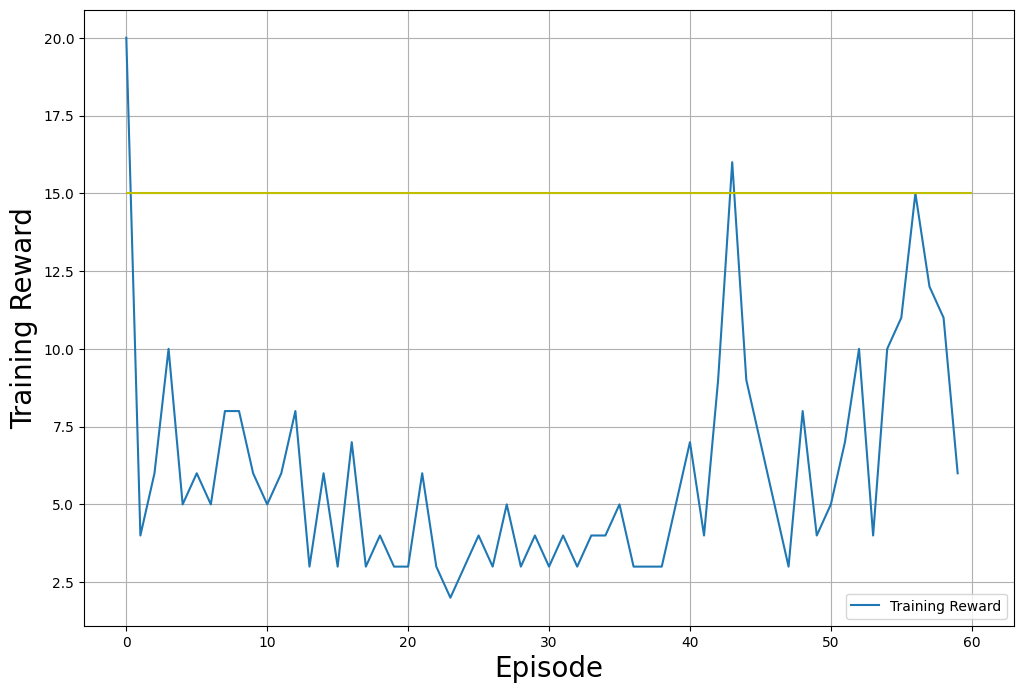

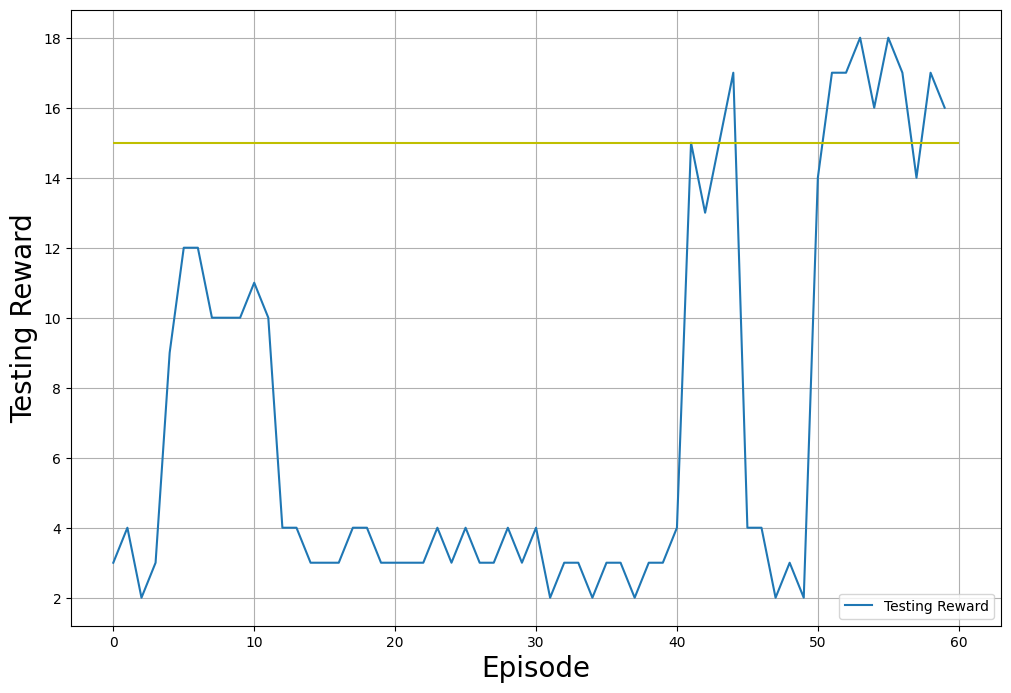

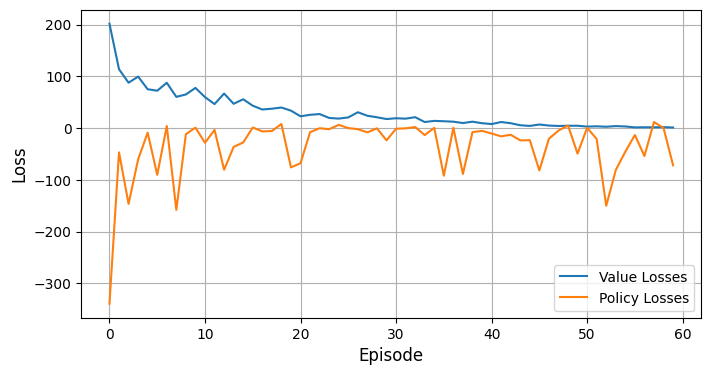

In [46]:
run_agent(algorithm="A2C")